Goal: Build a car detector with YOLO

In [1]:
# mount google drive. data and utils 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Coursera/Coursera_DeepLearningSpecialization/course4_coding_assignments/W3A1/

Mounted at /gdrive
/gdrive/My Drive/Coursera/Coursera_DeepLearningSpecialization/course4_coding_assignments/W3A1


In [2]:
!ls

 Autonomous_driving_application_Car_detection.ipynb   images	   out
 C4WK3_YAD2K.ipynb				      LICENSE	   yad2k
'Drive.ai Dataset Sample LICENSE'		      model_data
 font						      nb_images


In [4]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image 
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, read_classes, read_anchors, preprocess_image

%matplotlib inline

In [5]:
from IPython.display import HTML
url = 'https://drive.google.com/uc?id=17_1MhihINWfarwA8-gSjpwp8XlxFXgz0'
HTML(f"""<video src={url} width=500 controls/>""")

You Only Look Once
- input: a batch of images (m, 608, 608, 3)
- output: a list of bounding boxes ($p_c, b_x, b_y, b_h, b_w, c$)
- the dimension of encoding tensor ($m, n_H, n_W, anchors, classes$)
- YOLO architecture: IMAGE (m,608,608,3) -> Deep CNN -> Encoding (m,19,19,5,85)

[YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)

Encoding 


<img src="https://drive.google.com/uc?id=1hrP6PqtL2D_S7XaJQ5wbsi1d8RheC68y
">

Class score 

<img src="https://drive.google.com/uc?id=19oAVVidAPOQabybSxxQF_u8erNf_ocQh
">


<img src="https://drive.google.com/uc?id=1_9ZEejprIY4l046Eh4HK6RPz_eaSPtXi
">


https://github.com/allanzelener/YAD2K/blob/a42c760ef868bc115e596b56863dc25624d2e756/yad2k/models/keras_yolo.py#L309

In [6]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
  """
  Filter YOLO boxes based on object and class confidence
  Args:
    boxes: (19, 19, 5, 4)
    box_confidence: (19, 19, 5, 1)
    box_class_probs: (19, 19, 5, 80)
    threshold: highest class prob should >= threshold

  Returns: 
    scores: class probability score for selected boxes. Shape: (None,)
    boxes: (b_x, b_y, b_h, b_w) coordinates of selected boxes. Shape: (None, 4)
    classes: index of the classes detected by the selected boxes. Shape: (None,)
  """
  box_scores = box_confidence * box_class_probs # (19, 19, 5, 80)
  box_classes = tf.math.argmax(box_scores, axis = -1) # select the last axis 
  box_class_scores = tf.math.reduce_max(box_scores, axis = -1) # (19, 19, 5)

  filtering_mask = box_class_scores >= threshold

  boxes = tf.boolean_mask(boxes, filtering_mask)
  scores = tf.boolean_mask(box_class_scores, filtering_mask)
  classes = tf.boolean_mask(box_classes, filtering_mask)

  return scores, boxes, classes


In [7]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

assert type(scores) == EagerTensor, "Use tensorflow functions"
assert type(boxes) == EagerTensor, "Use tensorflow functions"
assert type(classes) == EagerTensor, "Use tensorflow functions"

assert scores.shape == (1789,), "Wrong shape in scores"
assert boxes.shape == (1789, 4), "Wrong shape in boxes"
assert classes.shape == (1789,), "Wrong shape in classes"

assert np.isclose(scores[2].numpy(), 9.270486), "Values are wrong on scores"
assert np.allclose(boxes[2].numpy(), [4.6399336, 3.2303846, 4.431282, -2.202031]), "Values are wrong on boxes"
assert classes[2].numpy() == 8, "Values are wrong on classes"

print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)
 All tests passed!


## Non-max Suppression

<img src="https://drive.google.com/uc?id=1lvwPkyNN1guMUJNqn66Vmc1iNe4Zsm12">



<img src="https://drive.google.com/uc?id=1Uc1c-5fAxtLzs_7CnhL_0qTvKna7-gQK">



In [8]:
def yolo_boxes_to_corners(box_xy, box_wh):
  """
  Convert YOLO box predictions to bounding box corners. 
  """
  box_mins = box_xy - (box_wh / 2.)
  box_maxes = box_xy + (box_wh / 2.)
  return tf.keras.backend.concatenate([
        box_mins[..., 1:2],
        box_mins[..., 0:1],
        box_maxes[..., 1:2],
        box_maxes[..., 0:1],
  ])


In [25]:
def scale_boxes(boxes, image_shape):
  # scale boxes to original image shape 
  height = float(image_shape[0]) # otherwise cannot multiply float and int
  width = float(image_shape[1])
  image_dims = tf.keras.backend.stack([height, width, height, width])
  image_dims = tf.keras.backend.reshape(image_dims, [1,4])
  boxes = boxes * image_dims
  return boxes

In [29]:
def yolo_non_max_suppression(scores, boxes, classes, 
                             max_boxes = 10, iou_threshold = 0.5):
  """
  Arguments: 
  scores: (None,)
  boxes: (None,4)
  classes: (None,)
  max_boxes: int
  iou_threshold: float

  Returns: 
  scores: (None,)
  boxes: (None,4)
  classes: (None,)
  """
  max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')
  nms_indices = tf.image.non_max_suppression(
      boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold
  )
  scores = tf.gather(scores, nms_indices)
  boxes = tf.gather(boxes, nms_indices) # gather works like a filter
  classes = tf.gather(classes, nms_indices)
  return scores, boxes, classes

https://github.com/allanzelener/YAD2K/blob/a42c760ef868bc115e596b56863dc25624d2e756/yad2k/models/keras_yolo.py#L323

In [31]:
def yolo_eval(yolo_outputs, 
              image_shape = (720, 1280), 
              max_boxes = 10,
              score_threshold = 0.6, 
              iou_threshold = 0.5):
  box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
  boxes = yolo_boxes_to_corners(box_xy, box_wh)
  scores, boxes, classes = yolo_filter_boxes(
      boxes, box_confidence, box_class_probs, 
      threshold = score_threshold
  )
  
  boxes = scale_boxes(boxes, image_shape)
  scores, boxes, classes = yolo_non_max_suppression(scores, 
                                                    boxes, 
                                                    classes, 
                                                    max_boxes = max_boxes, 
                                                    iou_threshold = iou_threshold)
  return scores, boxes, classes


In [32]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"
    
assert np.isclose(scores[2].numpy(), 171.60194), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [-1240.3483, -3212.5881, -645.78, 2024.3052]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 16), "Wrong value on classes"
    
print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


## Test YOLO Pre-trained Model

In [33]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [34]:
yolo_model = load_model("model_data/", compile=False)

In [35]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [37]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test.jpg
car 0.89 (367, 300) (745, 648)
car 0.80 (761, 282) (942, 412)
car 0.74 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 705)
bus 0.67 (5, 266) (220, 407)
car 0.66 (706, 279) (786, 350)
car 0.60 (925, 285) (1045, 374)
car 0.44 (336, 296) (378, 335)
car 0.37 (965, 273) (1022, 292)
traffic light 0.36 (681, 195) (692, 214)


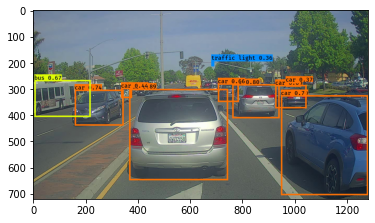

In [38]:
out_scores, out_boxes, out_classes = predict("test.jpg")